# Import packages

In [128]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import pickle
import time

torch.set_default_dtype(torch.float)

# Define classes for parameter-container and sequence generator

In [129]:
"""
Class MassFricParams, manages data of a mass block sliding on rate-and-state friction surface, contains 
    Data:
        k : Spring stiffness
        m : Mass of the block
        V : Leading head speed of the spring
        g : Gravity
        RSParams : rate and state parameters, torch.tensor([a, b, DRS, f*])
        y0 : torch.tensor([initial x_1, initial v_1, initial state variable])
"""
class MassFricParams: 
    # Constructor
    def __init__(self, k, m, V, g, RSParams, y0):
        self.k = k
        self.m = m
        self.V = V
        self.g = g
        self.RSParams = RSParams
        self.y0 = y0
    
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Mass and spring parameters ", "-"*20)
        print('k:        ', self.k)
        print('g:        ', self.g)
        print('m:        ', self.m)
        print('\n')
        
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.RSParams[3])
        print('a:        ', self.RSParams[0])
        print('b:        ', self.RSParams[1])
        print('DRS:      ', self.RSParams[2])
        print('y0:       ', self.y0)
        

In [130]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        MFParams: Mass and friction parameters for the system
        T: Length of calculation
        
    Method:
        __init__ : Constructor
        calculateYAtT: Generate the sequence of [x_1, v_1, theta]
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, T, NofTPts, MFParams, rtol = 1.e-6, atol = 1.e-8, regularizedFlag = True):
        # Load the parameters
        self.T = T
        self.t = torch.linspace(0., T, NofTPts)
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        self.regularizedFlag = regularizedFlag
        
        # Generate the sequence
        st = time.time()
        self.default_y = self.calculateYAtT(self.t)
        self.time_cost = time.time() - st
        print("Time cost to generate the sequence: ", self.time_cost)
        
    # Function DyDt, DyDt = f(t, y)
    def DyDt(self, t, y):
        
        # Need to use regularized rate-and-state
        a = self.MFParams.RSParams[0]
        b = self.MFParams.RSParams[1]
        DRS = self.MFParams.RSParams[2]
        fStar = self.MFParams.RSParams[3]
        
        # Regularized rate-and-state friction
#         tau = self.N * a * torch.asinh(
#                    self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
#                    )
        
        if self.regularizedFlag:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (a * torch.asinh(
                                     y[1] / 2.e-6 * torch.exp((fStar + b * torch.log(1.e-6 * y[2] / DRS)) / a)
                                 )), 
                                 1 - y[2] * 1.e-6 / DRS])
        else:
            DyDt = torch.tensor([y[1], 
                                 self.MFParams.k / self.MFParams.m * (self.MFParams.V * t - y[0]) - \
                                 self.MFParams.g * (fStar + \
                                                    a * torch.log(y[1] / 1.e-6) + \
                                                    b * torch.log(1.e-6 * y[2] / DRS)), 
                                 1 - y[2] * 1.e-6 / DRS])             
        # DEBUG LINES
#         print("-" * 30)
#         print('t = ', t)
#         print('y = ', y)
#         print('DyDt = ', DyDt)
        
        return DyDt
    
    
    # Generate the sequence of y(t) = [x_1(t), v_1(t), theta(t)]
    def calculateYAtT(self, t):
        y = odeint(self.DyDt, self.MFParams.y0, t, 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        return torch.transpose(y, 0, 1)
    
    # Visualize the sequence of y
    def plotY(self, t, y):
        # Plot Sequence of V(t) and N(t) given sample-index
        f, axs = plt.subplots(2, 2, figsize = (15, 15))

        # Plot x_1(t)
        axs[0][0].plot(1e6 * t, y[0, :], linewidth=2.0)
        axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][0].set_ylabel('Slip $x_1(t)\  \mathrm{[m]}$', fontsize=20)
        # axs[0][0].set_ylim([1e-15, 1e2])
        axs[0][0].grid()

        # Plot v_1(t)
        axs[0][1].semilogy(1e6 * t, y[1, :], linewidth=2.0)
        axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[0][1].set_ylabel('Slip rate $v_1(t)\ \mathrm{[m/s]}$', fontsize=20)
        # axs[0][1].set_ylim([0, 15])
        axs[0][1].grid()

        # Plot theta(t)
        axs[1][0].semilogy(1e6 * t, y[2, :], linewidth=3.0)
        axs[1][0].semilogy(1e6 * t, self.MFParams.RSParams[2] / y[1, :], linewidth=2.0)
        axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
        axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
        axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
        axs[1][0].grid()

#         # Plot \tau(t)
#         axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
#         axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
#         axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
#         axs[1][1].grid()

#         f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)


# Adjoint derivatives

In [131]:
## O = \int_0^T (y[1](t) - v(t)) ^ 2 dt 
# To compute dO / d \beta, one needs to implement six functions
# In all tensors, the last dimension is time

# \partial o(y, yDot, t; \beta) / \partial y
def DoDy(y, v, t, MFParams):
    DoDy = torch.zeros(y.shape)
    DoDy[1, :] = 2. * (y[1, :] - v)
    return DoDy

# \partial o / \partial yDot
def DoDyDot(y, v, t, MFParams):
    return torch.zeros(y.shape)

# d/dt (\partial o / \partial yDot)
def DDoDyDotDt(y, v, t, MFParams):
    return torch.zeros(y.shape)

# \partial o / \partial \beta
def DoDBeta(y, v, t, MFParams):
    return torch.zeros([MFParams.RSParams.shape[0], y.shape[1]])

# \partial C / \partial y, unregularized
def DCDy(y, v, t, MFParams):
    DCDy = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDy[0, 1, :] = -1.
    DCDy[1, 0, :] = MFParams.k / MFParams.m
    DCDy[1, 1, :] = MFParams.g * MFParams.RSParams[0] / y[1, :]
    DCDy[1, 2, :] = MFParams.g * MFParams.RSParams[1] / y[2, :]
    DCDy[2, 1, :] = y[2, :] / MFParams.RSParams[2]
    DCDy[2, 2, :] = y[1, :] / MFParams.RSParams[2]
    return DCDy

# \partial C / \partial yDot, unregularized
def DCDyDot(y, v, t, MFParams):
    DCDyDot = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    DCDyDot[0, 0, :] = 1.
    DCDyDot[1, 1, :] = 1.
    DCDyDot[2, 2, :] = 1.
    return DCDyDot

# d/dt (\partial C / \partial yDot)
def DDCDyDotDt(y, v, t, MFParams):
    DDCDyDotDt = torch.zeros([y.shape[0], y.shape[0], y.shape[1]])
    return DDCDyDotDt

# \partial C / \partial \beta
def DCDBeta(y, v, t, MFParams):
    DCDBeta = torch.zeros([y.shape[0], MFParams.RSParams.shape[0], y.shape[1]])
    DCDBeta[1, 0, :] = MFParams.g * torch.log(y[1, :] / 1.e-6)
    DCDBeta[1, 1, :] = MFParams.g * torch.log(1.e-6 * y[2, :] / MFParams.RSParams[2])
    DCDBeta[1, 2, :] = -MFParams.g * MFParams.RSParams[1] / MFParams.RSParams[2]
    DCDBeta[1, 3, :] = MFParams.g
    DCDBeta[2, 2, :] = -y[1, :] * y[2, :] / MFParams.RSParams[2] / MFParams.RSParams[2]
    return DCDBeta

# ------------------------ Calculate the derivative: Do / D\beta -------------------------
# Observation
def O(y, v, t, MFParams):
    # Least square error
    O = torch.trapezoid(
        torch.square(y[1, :] - v), 
        t
    )
    
    print("Relative L2 error: ", torch.sqrt(O) / torch.linalg.norm(v))
    return O

    

In [132]:
# Class Adjoint derivatives
class AdjDerivs:
    # Constructor
    def __init__(self, y, v, t, MFParams, rtol = 1.e-6, atol = 1.e-8):
        self.y = y
        self.v = v
        self.t = t
        
        # Define tau = T - t
        self.T = self.t[-1]
        self.tau = self.T - self.t
        
        # self.tau = torch.flip(self.T - self.t, [0])
        
        self.MFParams = MFParams
        self.rtol = rtol
        self.atol = atol
        
        ## Calculate the partial derivatives ##
        self.dCdy = DCDy(y, v, t, MFParams)
        self.dody = DoDy(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        self.ddCdyDotdt = DDCDyDotDt(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.ddodyDotdt = DDoDyDotDt(y, v, t, MFParams)
        self.dCdBeta = DCDBeta(y, v, t, MFParams)
        self.dodBeta = DoDBeta(y, v, t, MFParams)
        self.dodyDot = DoDyDot(y, v, t, MFParams)
        self.dCdyDot = DCDyDot(y, v, t, MFParams)
        
        # Calculate A_z and u_z
        self.Az = self.A_z()
        self.uz = self.u_z()
        
        # Calculate A_l and u_l
        self.Al = self.A_l()
        self.ul = self.u_l()
        
        # Calculate dOdBeta
        st = time.time()
        self.dOdBeta = self.DODBeta()
        self.time_cost = time.time() - st
        print("Time cost in computing gradients: ", self.time_cost)
    
    ## d\lambda / dtau = f_l(l, tau) = -(l \cdot A_l(tau) + u_l(tau)) ##
    # calculate A_l at tau
    def A_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dCdy = torch.transpose(self.dCdy, 2, 0)
        ddCdyDotdt = torch.transpose(self.ddCdyDotdt, 2, 0)
        
        # Calculate A_l at tSteps
        A_l_discrete = torch.linalg.solve(dCdyDot, dCdy - ddCdyDotdt)
        A_l_discrete = torch.transpose(A_l_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_l_discrete = A_l_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        A_l_discrete_temp = torch.concat([A_l_discrete[:, :, [0]], A_l_discrete, A_l_discrete[:, :, [-1]]], -1)
        
        # Return the function
        # A_l = interp1d(self.T - t_temp, A_l_discrete_temp, kind="cubic")
        A_l = interp1d(self.T - t_temp, A_l_discrete_temp)
        return A_l
    
    # Calculate u_l at tau
    def u_l(self):
        dCdyDot = torch.transpose(self.dCdyDot, 2, 0)
        dody = torch.transpose(self.dody, 1, 0)
        ddodyDotdt = torch.transpose(self.ddodyDotdt, 1, 0)
        
        # Calculate u_l at tSteps
        u_l_discrete = torch.linalg.solve(dCdyDot, dody - ddodyDotdt)
        u_l_discrete = torch.movedim(u_l_discrete, 0, 1)
        
        # DEBUG LINES
        self.u_l_discrete = u_l_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.]), self.t, torch.tensor([self.t[-1] + 1.])], 0)
        u_l_discrete_temp = torch.concat([u_l_discrete[:, [0]], u_l_discrete, u_l_discrete[:, [-1]]], -1)
        
        # Return the function
        # u_l = interp1d(self.T - t_temp, u_l_discrete_temp, kind="cubic")
        u_l = interp1d(self.T - t_temp, u_l_discrete_temp)
        return u_l
    
    # Calculate f_l(self, tau, l)
    def f_l(self, tau, l):
        tau = torch.clip(tau, self.t[0], self.t[-1])
        res = -torch.matmul(l, torch.tensor(self.Al(tau), dtype=torch.float)) - \
              torch.tensor(self.ul(tau), dtype=torch.float)
        return res
    
    ## dz / dt = f_z(z, t) = A_z(t) \cdot z + u_z(t) ##
    # Calculate A_z at t
    def A_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdy = torch.movedim(self.dCdy, 2, 0)
        
        # Calculate A_z at tSteps
        A_z_discrete = -torch.linalg.solve(dCdyDot, dCdy)
        A_z_discrete = torch.movedim(A_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.A_z_discrete = A_z_discrete
        
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        A_z_discrete_temp = torch.concat([A_z_discrete[:, :, [0]], A_z_discrete, A_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        A_z = interp1d(t_temp, A_z_discrete_temp, kind="cubic")
        return A_z
    
    # Calculate u_z at t
    def u_z(self):
        dCdyDot = torch.movedim(self.dCdyDot, 2, 0)
        dCdBeta = torch.movedim(self.dCdBeta, 2, 0)
        
        # Calculate A_z at tSteps
        u_z_discrete = -torch.linalg.solve(dCdyDot, dCdBeta)
        u_z_discrete = torch.movedim(u_z_discrete, 0, 2)
        
        # DEBUG LINES
        self.u_z_discrete = u_z_discrete
    
        # Compute the interpolation for slip rate Ds
        t_temp = torch.concat([torch.tensor([self.t[0] - 1.0]), self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        u_z_discrete_temp = torch.concat([u_z_discrete[:, :, [0]], u_z_discrete, u_z_discrete[:, :, [-1]]], -1)
        
        # Return the function
        u_z = interp1d(t_temp, u_z_discrete_temp, kind="cubic")
        return u_z
    
    # Calculate f_z
    def f_z(self, t, z):
        
        res = torch.matmul(torch.tensor(self.Az(t), dtype=torch.float), z) + \
              torch.tensor(self.uz(t), dtype=torch.float)
        
        
#         # DEBUG LINES
#         print("-" * 40)
#         print('t = ', t)
#         print('z = ', z)
#         print('f_z: ', res)
        
        return res
    
    # d observation / d \beta
    def DODBeta(self):
        ## First solve for lambda(t) ##
        A = self.dCdy - self.ddCdyDotdt
        B = -self.dody + self.ddodyDotdt

        # Switch dimensions by torch.transpose
        A = torch.transpose(A, 0, 2)
        B = torch.transpose(B, 0, 1)

        # Solve for lambda [Tsteps, ]
        # L = torch.linalg.solve(A, B)
        L0 = torch.zeros(self.y.shape[0])
        
        # Solve for L(t)
        L = odeint(self.f_l, L0, torch.flip(self.tau, [0]), 
                   rtol = self.rtol, atol = self.atol, method = 'dopri5')
        
        L = L.reshape([L.shape[0], 1, L.shape[1]])
        L = torch.flip(L, [0])
        LDCDBeta = torch.movedim(self.dCdBeta, 2, 0)
        LDCDBeta = torch.matmul(L, LDCDBeta)
        LDCDBeta = LDCDBeta.reshape([LDCDBeta.shape[0], LDCDBeta.shape[2]])

#         # DEBUG LINES
#         print('L shape: ', L.shape)
#         print('LDCDBeta shape: ', LDCDBeta.shape)
#         print('L[-1, :, :]: ', L[-1, :, :])
        
        integrand = self.dodBeta + torch.transpose(LDCDBeta, 0, 1)
        DODBeta = torch.trapezoid(
            integrand, 
            self.t
        )
        
        
        
#         ## Then calculate z(T) ##
#         z0 = torch.zeros([self.y.shape[0], self.MFParams.RSParams.shape[0]])
#         zT = odeint(self.f_z, z0, self.t, 
#                     rtol = 1.e-10, atol = 1.e-12, method = 'dopri5')
#         zT_last = zT[-1, :, :]
        
#         # DEBUG LINES 
#         print("zT_last: ", zT_last)
#         print("LT: ", L[-1, :, :])
        
        # DEBUG LINES 
        print('DODBeta: ', DODBeta)
        
#         DODBeta += ((self.dodyDot[:, -1] + L[-1, :, :] @ self.dCdyDot[:, :, -1]) @ zT_last).reshape([-1])
#         print('DODBeta after boundary term: ', DODBeta)
        
#         ## USE THE ALTERNATIVE WAY
#         DODBeta_alter = torch.trapezoid(
#             2 * (self.y[1, :] - self.v) * torch.transpose(zT[:, 1, :], 0, 1), 
#             self.t
#         )
#         print('DODBeta alternative ', DODBeta_alter)
        
        return DODBeta
        

# Fixed parameters

In [153]:
## Fixed parameters
# Parameters for the spring-slider
k = 50.
m = 1.
V = 1.
g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-6
this_atol = 1.e-8

# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_SpringSlider = MassFricParams(k, m, V, g, targ_RSParams, y0)

targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
v = targ_seq.default_y[1, :]

Time cost to generate the sequence:  0.3256230354309082


# Updating using gradient descent

In [175]:
# Function observation function
def objGradFunc(beta, targ_y, objOnly = False):
    # Generate target v
    this_RSParams = torch.tensor(beta)
    this_SpringSlider = MassFricParams(k, m, V, g, targ_RSParams, y0)

    this_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, 
                               rtol=this_rtol, atol=this_atol, regularizedFlag=False)
    
    # Compute the value of objective function
    obj = O(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider)
    
    # Compute dOdBeta
    if objOnly:
        grad = 0.
    else:
        myAdj = AdjDerivs(this_seq.default_y, targ_y, this_seq.t, this_SpringSlider, 
                          rtol = 1.e-6, atol = 1.e-8)
        grad = myAdj.dOdBeta
        
    return obj, grad


# Give the initial position and gradient updating function
class GradDescent:
    # Constructor, initial value position
    def __init__(self, beta0, targ_y, t, objGrad_func, max_steps, obs_rtol = 1e-5, lsrh_steps = 4):
        # Initial parameters
        self.beta0 = beta0
        
        # Target sequence
        self.targ_y = targ_y
        
        # Time at which targ_y was observed
        self.t = t
        
        # Objective and gradient function
        self.objGrad_func = objGrad_func
        
        # Maximum number of steps allowed
        self.max_steps = max_steps
        
        # Tolerance of observation relative error
        self.obs_tol = obs_rtol
        
        # Sequence of parameters
        self.betas = [beta0]
        
        # Maximum line search steps
        self.lsrh_steps = lsrh_steps
        
        # Get Initial observations
        self.objs = []
    
    # First descent, cannot use Barzilai–Borwein stepping, using linesearch
    def firstDescent(self):
        # Compute obj and grad
        obj, grad = self.objGrad_func(self.betas[-1], self.targ_y)
        self.objs = [obj]
        self.grads = [grad]
        
        # Find stepsize
        maxStepSize = 0.1 * min(abs(beta0 / grad))
        
        # Line search
        stepSize = maxStepSize
        for i in range(self.lsrh_steps):
            beta_trial = self.beta0 - stepSize * grad
            obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, objOnly = True)
            
            # Break if this beta is good
            if obj_trial < obj:
                break
            
            # Half the stepSize
            stepSize = stepSize / 2.
        
        # Append the betas and objs
        obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, objOnly = False)
        self.betas.append(beta_trial)
        self.objs.append(obj_trial)
        self.grads.append(grad_trial)
        
        # Return if obj_trial is smaller than obj
        return obj_trial < obj
    
    # Run one descent using Barzilai–Borwein stepping
    def oneDescent(self):
        # Make sure there are more than 1 steps beforehand
        assert(len(self.objs) >= 2)
        
        # Calculate the step size
        stepSize = abs(torch.dot(self.betas[-1] - self.betas[-2], self.grads[-1] - self.grads[-2])) / \
                   torch.sum(torch.square(self.grads[-1] - self.grads[-2]))
        beta_trial = self.betas[-1] - stepSize * self.grads[-1]
        
        # Append the betas and objs
        obj_trial, grad_trial = self.objGrad_func(beta_trial, self.targ_y, objOnly = False)
        self.betas.append(beta_trial)
        self.objs.append(obj_trial)
        self.grads.append(grad_trial)
        
        # Return if obj_trial is smaller than obj
        return obj_trial < self.objs[-2]
    
    # Run gradient descent
    def run(self):
        # Run initial descent
        success = self.firstDescent()
        print("=" * 40)
        print("Initial descent: ", success)
        print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
        
        # Run max_iters number of iterations
        for i in range(self.max_steps):
            success = self.oneDescent()
            print("=" * 40)
            print("The {0}th descent: ".format(i + 1), success)
            print("Observation: ", self.objs[-1])
            print("Gradient: ", self.grads[-1])
            print("Relative error of observation: ", torch.sqrt(self.objs[-1]) / torch.linalg.norm(self.targ_y))
        
        # Return
        return

# One gradient descent example

In [176]:
# Initialize a grad example
beta0 = torch.tensor([0.008, 0.012, 2.e-3, 0.58])
myGrad = GradDescent(beta0, v, targ_seq.t, objGrad_func = objGradFunc, max_steps = 10, obs_rtol = 1e-5, lsrh_steps = 4)

In [177]:
myGrad.run()

/tmp/ipykernel_1792902/1684394348.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  this_RSParams = torch.tensor(beta)


Time cost to generate the sequence:  0.30698442459106445
Relative L2 error:  tensor(0.)
DODBeta:  tensor([0., 0., 0., 0.])
Time cost in computing gradients:  0.08248281478881836
Time cost to generate the sequence:  0.26823949813842773
Relative L2 error:  tensor(0.)
Time cost to generate the sequence:  0.3001861572265625
Relative L2 error:  tensor(0.)
Time cost to generate the sequence:  0.2659337520599365
Relative L2 error:  tensor(0.)
Time cost to generate the sequence:  0.26526498794555664
Relative L2 error:  tensor(0.)
Time cost to generate the sequence:  0.26523828506469727
Relative L2 error:  tensor(0.)
DODBeta:  tensor([0., 0., 0., 0.])
Time cost in computing gradients:  0.08209443092346191
Initial descent:  tensor(False)
Relative error of observation:  tensor(0.)
Time cost to generate the sequence:  0.26581287384033203
Relative L2 error:  tensor(0.)
DODBeta:  tensor([0., 0., 0., 0.])
Time cost in computing gradients:  0.08208155632019043
The 1th descent:  tensor(False)
Observati

## Give an example:

In [133]:
## Fixed parameters
# Parameters for the spring-slider
k = 50.
m = 1.
V = 1.
g = 9.8
y0 = torch.tensor([0., 1.0, 1.0])

# Sequence specific parameters
T = 5.
NofTPts = 1000

# Tolerance parameters
this_rtol = 1.e-6
this_atol = 1.e-8

Time cost to generate the sequence:  0.3368046283721924


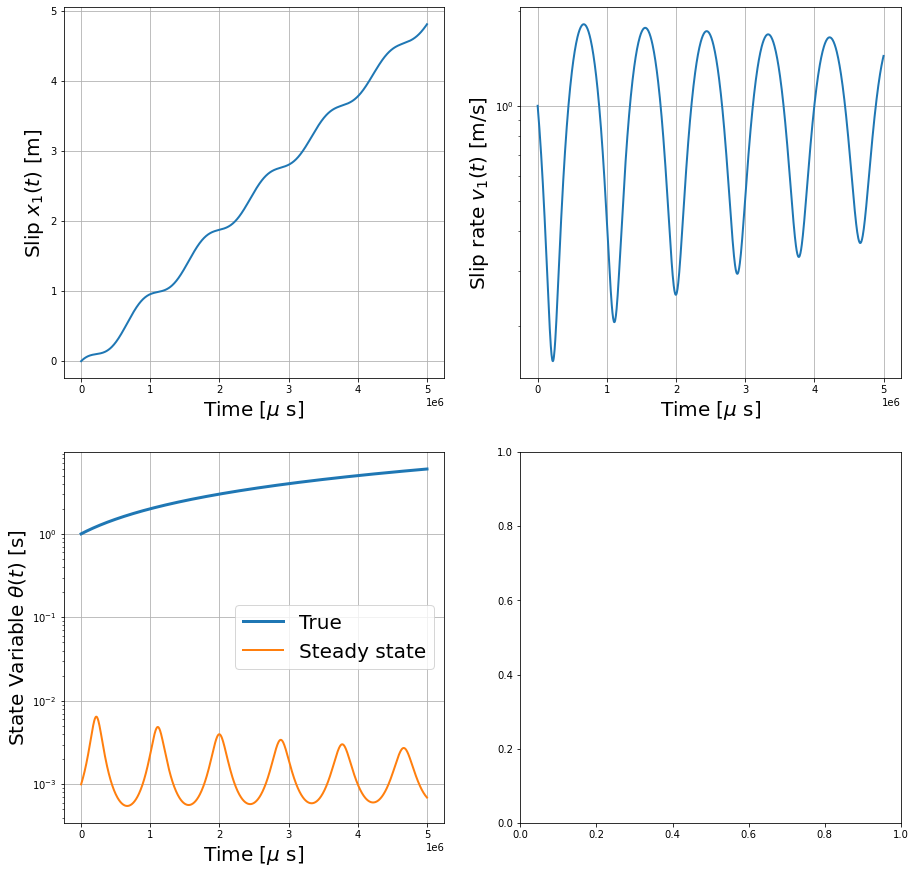

In [134]:
# Generate target v
targ_RSParams = torch.tensor([0.011, 0.016, 1.e-3, 0.58])
targ_SpringSlider = MassFricParams(k, m, V, g, targ_RSParams, y0)

targ_seq = TimeSequenceGen(T, NofTPts, targ_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
v = targ_seq.default_y[1, :]
targ_seq.plotY(targ_seq.t, targ_seq.default_y)

Time cost to generate the sequence:  0.32443785667419434


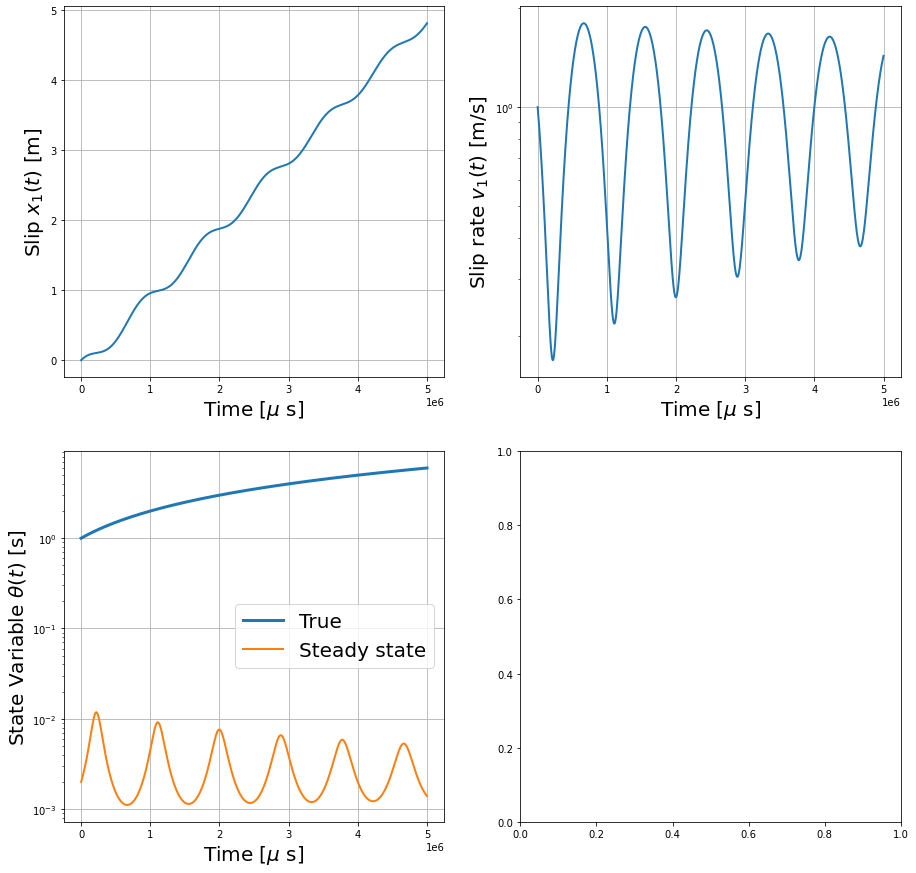

In [135]:
# A new set of RS params
# new_RSParams = torch.tensor([0.004, 0.008, 2., 0.6])
new_RSParams = torch.tensor([0.011, 0.016, 2.e-3, 0.58])
new_SpringSlider = MassFricParams(k, m, V, g, new_RSParams, y0)
new_seq = TimeSequenceGen(T, NofTPts, new_SpringSlider, rtol=this_rtol, atol=this_atol, regularizedFlag=False)
new_seq.plotY(new_seq.t, new_seq.default_y)

In [136]:
# Report observation:
Obs = O(new_seq.default_y, v, new_seq.t, new_SpringSlider)
print('Observation vector: ', Obs)

Relative L2 error:  tensor(0.0005)
Observation vector:  tensor(0.0003)


In [125]:
# Calculate DoDBeta
myADJ = AdjDerivs(new_seq.default_y, v, new_seq.t, new_SpringSlider, rtol = 1.e-6, atol = 1.e-8)


DODBeta:  tensor([-0.5679,  0.6794,  0.0117, -0.0897])
Time cost in computing gradients:  2.3099114894866943


In [126]:
myADJ.T

tensor(5.)

In [127]:
# Get the finite-difference gradients
perturbRatio = 0.001
numericalGrad = torch.zeros(new_RSParams.shape)
Rtol = 1.e-10
Atol = 1.e-12

# Loop through all beta's components
for i in range(len(new_RSParams)):
    RSParamsPlus = torch.clone(new_RSParams)
    RSParamsPlus[i] = RSParamsPlus[i] * (1 + perturbRatio)
    RSParamsMinus = torch.clone(new_RSParams)
    RSParamsMinus[i] = RSParamsMinus[i] * (1 - perturbRatio)
    
    print("-" * 40)
    print("RSParams: ", new_RSParams)
    print("RSParamsPlus: ", RSParamsPlus)
    print("RSParamsMinus: ", RSParamsMinus)
    
    # Calculate two observations
    SpringSliderPlus = MassFricParams(k, m, V, g, RSParamsPlus, y0)
    seqPlus = TimeSequenceGen(T, NofTPts, SpringSliderPlus, Rtol, Atol, regularizedFlag=False)
    OPlus = O(seqPlus.default_y, v, seqPlus.t, SpringSliderPlus)
    
    SpringSliderMinus = MassFricParams(k, m, V, g, RSParamsMinus, y0)
    seqMinus = TimeSequenceGen(T, NofTPts, SpringSliderMinus, Rtol, Atol, regularizedFlag=False)
    OMinus = O(seqMinus.default_y, v, seqMinus.t, SpringSliderMinus)
    
    numericalGrad[i] = (OPlus - OMinus) / (RSParamsPlus[i] - RSParamsMinus[i])

print('Numerical gradient: ', numericalGrad)

----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to generate the sequence:  18.004094123840332
Relative L2 error:  tensor(0.0005)
Time cost to generate the sequence:  16.35990333557129
Relative L2 error:  tensor(0.0005)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to generate the sequence:  16.547524213790894
Relative L2 error:  tensor(0.0005)
Time cost to generate the sequence:  16.958455085754395
Relative L2 error:  tensor(0.0005)
----------------------------------------
RSParams:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsPlus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
RSParamsMinus:  tensor([0.0110, 0.0160, 0.0020, 0.5800])
Time cost to genera